<a href="https://colab.research.google.com/github/voquyen0502/Protein-Ligand-Binding-Affinity/blob/main/Protein_Ligand_Affinity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Install Library

In [ ]:
!pip install -U sentence-transformers
#!pip install git+https://github.com/jglaser/sentence-transformers.git@enable_mixed

!pip install Bio
!pip install rdkit
!pip install pint

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#Import Library

In [ ]:
import pandas as pd
import torch
import numpy as np
import dask.array as da
from sentence_transformers import SentenceTransformer

import warnings
from Bio.PDB import PDBParser, PPBuilder, CaPPBuilder
from Bio.PDB.NeighborSearch import NeighborSearch
from Bio.PDB.Selection import unfold_entities
from rdkit import Chem

import os
import re
import glob
import gc
import time

from pint import UnitRegistry

#Download Dataset

In [ ]:
!wget https://pdbbind.oss-cn-hangzhou.aliyuncs.com/download/PDBbind_v2020_refined.tar.gz
!tar -xvzf PDBbind_v2020_refined.tar.gz
!rm -f PDBbind_v2020_refined.tar.gz

Streaming output truncated to the last 5000 lines.
refined-set/1fkh/
refined-set/1fkh/1fkh_protein.pdb
refined-set/1fkh/1fkh_pocket.pdb
refined-set/1fkh/1fkh_ligand.sdf
refined-set/1fkh/1fkh_ligand.mol2
refined-set/2f8g/
refined-set/2f8g/2f8g_ligand.mol2
refined-set/2f8g/2f8g_pocket.pdb
refined-set/2f8g/2f8g_ligand.sdf
refined-set/2f8g/2f8g_protein.pdb
refined-set/6elp/
refined-set/6elp/6elp_ligand.mol2
refined-set/6elp/6elp_pocket.pdb
refined-set/6elp/6elp_protein.pdb
refined-set/6elp/6elp_ligand.sdf
refined-set/4v27/
refined-set/4v27/4v27_ligand.sdf
refined-set/4v27/4v27_pocket.pdb
refined-set/4v27/4v27_ligand.mol2
refined-set/4v27/4v27_protein.pdb
refined-set/5fsc/
refined-set/5fsc/5fsc_protein.pdb
refined-set/5fsc/5fsc_ligand.sdf
refined-set/5fsc/5fsc_ligand.mol2
refined-set/5fsc/5fsc_pocket.pdb
refined-set/1fh8/
refined-set/1fh8/1fh8_ligand.sdf
refined-set/1fh8/1fh8_pocket.pdb
refined-set/1fh8/1fh8_ligand.mol2
refined-set/1fh8/1fh8_protein.pdb
refined-set/3gnw/
refined-set/3gnw/3g

#Preprocessing

In [ ]:
skip_list = ['3pcn', '3t08', '4kwg', '4fp1', '1b58', '4b6s', '3t09', '5jzi', '4ij1', '3pcf', '2cer', '2b7d', '3pfp', '3pcg', '2cht', '4aq6', '4ucc'] #skip because of being not enough RAM
error_list = ['index', 'readme', '4kcx', '1sl3', '1ksn', '1mue']

In [ ]:
def format_time(time):
  if len(time) < 2:
    return "0"+time
  return time
def to_time(t):
  s = format_time(str(t%60))
  m = format_time(str(t//60%60))
  h = format_time(str(t//3600))
  return h+":"+m+":"+s
def progress_bar(desc, t, i, n):
  eta = int(t*(n-i)/i) if i else 0
  pg = round(i*40/n)
  print('\r'+desc, '[ elapsed:', to_time(t),']', "|"+"="*pg+" "*(40-pg)+"|", str(round(i*100/n))+"%", '( ETA:', to_time(eta), ')', end="", flush=True)

In [ ]:
def parse_complex(fn, i):
    name = os.path.basename(fn)
    if name in error_list or name in skip_list:
      return None
    try:
        # parse protein sequence and coordinates
        progress_bar("Parsing "+name+"...", int(time.time()-t), i, n_file)
        parser = PDBParser()
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            structure = parser.get_structure('protein',fn+'/'+name+'_protein.pdb')

        # ppb = PPBuilder()
        ppb = CaPPBuilder()
        protein = []
        for pp in ppb.build_peptides(structure):
            protein.append(str(pp.get_sequence()))
        protein = ''.join(protein)
        # # parse ligand, convert to SMILES and map atoms
        # ligand = ''
        # with Chem.SDMolSupplier(fn+'/'+name+'_ligand.sdf') as suppl:
        #   for mol in suppl:
        #     if mol is None: continue
        #     ligand = Chem.MolToSmiles(mol)
        # mol1 = Chem.MolFromPDBFile(fn+'/'+name+'_protein.pdb')
        # protein = Chem.MolToSequence(mol1)
        mol2 = Chem.MolFromMol2File(fn+'/'+name+'_ligand.mol2')
        ligand = Chem.MolToSmiles(mol2, isomericSmiles=True)
        return name, protein, ligand
    except Exception as e:
        print(e)
        return None

filenames = glob.glob('./refined-set/*')
n_file = len(filenames)
result = []
t = time.time()
# for fn in filenames:
for i in range(0, n_file):
    r = parse_complex(filenames[i], i)
    result.append(r)
result = [r for r in result if r is not None]

Parsing 4jfm... [ elapsed: 00:01:01 ] |===                                     | 7% ( ETA: 00:12:59 )

[13:10:44] 1bq4_ligand: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.


Parsing 4re4... [ elapsed: 00:03:21 ] |==========                              | 26% ( ETA: 00:09:26 )

[13:13:04] 4ew3_ligand: warning - charged amidine and isFixed atom.


Parsing 1q72... [ elapsed: 00:04:01 ] |=============                           | 32% ( ETA: 00:08:38 )

[13:13:44] 3mof_ligand: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.


Parsing 1ecq... [ elapsed: 00:04:10 ] |=============                           | 33% ( ETA: 00:08:19 )

[13:13:54] 4ew2_ligand: warning - charged amidine and isFixed atom.


Parsing 3a1e... [ elapsed: 00:04:22 ] |==============                          | 35% ( ETA: 00:08:00 )

[13:14:06] 1nki_ligand: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.


Parsing 3ip8... [ elapsed: 00:05:10 ] |=================                       | 42% ( ETA: 00:07:07 )

[13:14:54] 6gon_ligand: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.


Parsing 2a8g... [ elapsed: 00:06:59 ] |=======================                 | 57% ( ETA: 00:05:12 )

[13:16:43] 3t01_ligand: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.


Parsing 3k00... [ elapsed: 00:07:28 ] |========================                | 61% ( ETA: 00:04:44 )

[13:17:11] 2rk8_ligand: Warning - no explicit hydrogens in mol2 file but needed for formal charge estimation.


Parsing 5byi... [ elapsed: 00:12:28 ] |========================================| 100% ( ETA: 00:00:00 )

In [ ]:
names = [r[0] for r in result]
proteins = [r[1] for r in result]
ligands = [r[2] for r in result]
df1 = pd.DataFrame({'name': names, 'proteins': proteins, 'ligands': ligands})

In [ ]:
df1.head

<bound method NDFrame.head of       name                                           proteins  \
0     4knm  LSWGYREHNGPIHWKEFFPIADGDQQSPIEIKTKEVKYDSSLRPLS...   
1     2o4r  KLSEEQQHIIAILLDAHHKTYDPTYADFRDFRPPVRMPLSMLPHLA...   
2     2oax  PVMVLENIEPEIVYAGYDSDTAENLLSTLNRLAGKQMIQVVKWAKV...   
3     2wvz  KDWTQYVNPLMGSQSTFELSTGNTYPAIARPWGMNFWTPQTGKMGD...   
4     1hms  VDAFLGTWKLVDSKNFDDYMKSLGVGFATRQVASMTKPTTIIEKNG...   
...    ...                                                ...   
5290  4crl  DDKMDYDFKVKLSSERERVEDLFEYEGCKVGRGTYGHVYKAKRKDG...   
5291  1tnh  IVGGYTCGANTVPYQVSLNSGYHFCGGSLINSQWVVSAAHCYKSGI...   
5292  1w4o  KETAAAKFERQHMDSSTSAASSSNYCNQMMKSRNLTKDRCKPVNTF...   
5293  1kmy  SIRSLGYMGFAVSDVAAWRSFLTQKLGLMEAGTTDNGDLFRIDSRA...   
5294  5byi  HWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKPLSV...   

                                                ligands  
0         Cc1cc(C)nc(SCC(=O)c2ccc(S(N)(=O)=O)c(Cl)c2)n1  
1     C=C1[C@H](O)CC(=C/C=C2\CCC[C@]3(C)/C(=C(\C)CCC...  
2     CC(=O)S[C

In [ ]:
df2 = pd.read_table('./refined-set/index/INDEX_refined_data.2020',skiprows=4,sep=r'\s+',usecols=[0,4]).drop(0)
df2 = df2.rename(columns={'#': 'name','release': 'affinity'})
df2.head()

,name,affinity
1,2r58,Kd=10mM
2,3c2f,Kd=10.1mM
3,3g2y,Ki=10mM
4,3pce,Ki=10mM
5,4qsu,Kd=10mM


In [ ]:
quantities = ['ki','kd','ka','k1/2','kb','ic50','ec50']

In [ ]:
ureg = UnitRegistry()

def to_uM(affinity):
    val = ureg(affinity)
    try:
        return val.m_as(ureg.uM)
    except Exception:
        pass

    try:
        return 1/val.m_as(1/ureg.uM)
    except Exception:
        pass

In [ ]:
df2['affinity_uM'] = df2['affinity'].str.split('[=\~><]').str[1].apply(to_uM)
df2['affinity_quantity'] = df2['affinity'].str.split('[=\~><]').str[0]

<Axes: >

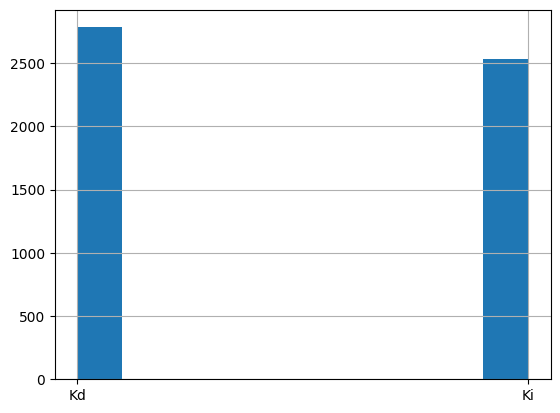

In [ ]:
df2['affinity_quantity'].hist()

In [ ]:
df2 = df2[df2['affinity_quantity'].str.lower().isin(quantities)]

In [ ]:
df2.head()

,name,affinity,affinity_uM,affinity_quantity
1,2r58,Kd=10mM,10000.0,Kd
2,3c2f,Kd=10.1mM,10100.0,Kd
3,3g2y,Ki=10mM,10000.0,Ki
4,3pce,Ki=10mM,10000.0,Ki
5,4qsu,Kd=10mM,10000.0,Kd


In [ ]:
df = df1.merge(df2,on='name').drop('affinity',axis=1)

In [ ]:
df.head()

,name,proteins,ligands,affinity_uM,affinity_quantity
0,4knm,LSWGYREHNGPIHWKEFFPIADGDQQSPIEIKTKEVKYDSSLRPLS...,Cc1cc(C)nc(SCC(=O)c2ccc(S(N)(=O)=O)c(Cl)c2)n1,0.010000,Kd
1,2o4r,KLSEEQQHIIAILLDAHHKTYDPTYADFRDFRPPVRMPLSMLPHLA...,C=C1[C@H](O)CC(=C/C=C2\CCC[C@]3(C)/C(=C(\C)CCC...,0.000400,Ki
2,2oax,PVMVLENIEPEIVYAGYDSDTAENLLSTLNRLAGKQMIQVVKWAKV...,CC(=O)S[C@@H]1CC2=CC(=O)CC[C@]2(C)[C@H]2CC[C@@...,0.002232,Ki
3,2wvz,KDWTQYVNPLMGSQSTFELSTGNTYPAIARPWGMNFWTPQTGKMGD...,O=C1N[C@@H]2[C@@H](O)[C@@H](O)[C@H](O)[C@@H](C...,96.000000,Ki
4,1hms,VDAFLGTWKLVDSKNFDDYMKSLGVGFATRQVASMTKPTTIIEKNG...,CCCCCCCC/C=C\CCCCCCCC(=O)[O-],0.430000,Kd


In [ ]:
df.dropna(inplace = True)

In [ ]:
df.shape

(5294, 5)

In [ ]:
df['neg_log10_affinity_M'] = 6-np.log(df['affinity_uM'])/np.log(10)

In [ ]:
df.head()

,name,proteins,ligands,affinity_uM,affinity_quantity,neg_log10_affinity_M
0,4knm,LSWGYREHNGPIHWKEFFPIADGDQQSPIEIKTKEVKYDSSLRPLS...,Cc1cc(C)nc(SCC(=O)c2ccc(S(N)(=O)=O)c(Cl)c2)n1,0.010000,Kd,8.000000
1,2o4r,KLSEEQQHIIAILLDAHHKTYDPTYADFRDFRPPVRMPLSMLPHLA...,C=C1[C@H](O)CC(=C/C=C2\CCC[C@]3(C)/C(=C(\C)CCC...,0.000400,Ki,9.397940
2,2oax,PVMVLENIEPEIVYAGYDSDTAENLLSTLNRLAGKQMIQVVKWAKV...,CC(=O)S[C@@H]1CC2=CC(=O)CC[C@]2(C)[C@H]2CC[C@@...,0.002232,Ki,8.651306
3,2wvz,KDWTQYVNPLMGSQSTFELSTGNTYPAIARPWGMNFWTPQTGKMGD...,O=C1N[C@@H]2[C@@H](O)[C@@H](O)[C@H](O)[C@@H](C...,96.000000,Ki,4.017729
4,1hms,VDAFLGTWKLVDSKNFDDYMKSLGVGFATRQVASMTKPTTIIEKNG...,CCCCCCCC/C=C\CCCCCCCC(=O)[O-],0.430000,Kd,6.366532


In [ ]:
#proteins = [{'protein': x} for x in df['proteins']]
#ligands = [{'ligand': x} for x in df['ligands']]

In [ ]:
gc.collect()

94573

In [ ]:
model = SentenceTransformer('jglaser/protein-ligand-mlp-3')

In [ ]:
outputs = []
t = time.time()
for idx, row in df.iterrows():
  progress_bar("Predicting "+row['name']+"...", int(time.time()-t), idx, df.shape[0])
  tokenized_p = model.tokenize([{'protein': row['proteins']}])
  tokenized_l = model.tokenize([{'ligand': row['ligands']}])
  embedding_p = model[0](tokenized_p)
  embedding_l = model[0](tokenized_l)
  output = {
      'sentence_embedding': torch.cat([embedding_p['sentence_embedding'], embedding_l['sentence_embedding']], dim=-1)
  }
  for j in range(1, len(model)):
    output = model[j](output)
  outputs += output['sentence_embedding'][0].tolist()
print(outputs)


Predicting 5byi... [ elapsed: 06:31:34 ] |========================================| 100% ( ETA: 00:00:00 )[7.886959075927734, 9.262880325317383, 7.699557304382324, 3.6247329711914062, 6.552060604095459, 4.253270149230957, 8.720772743225098, 4.501893997192383, 4.791064262390137, 8.833171844482422, 3.4276890754699707, 4.559718132019043, 8.211383819580078, 3.8681747913360596, 5.389044761657715, 5.915534496307373, 7.43961238861084, 6.890152931213379, 4.107139587402344, 7.775380611419678, 4.847503185272217, 7.357088088989258, 4.3583784103393555, 7.092879295349121, 5.699981689453125, 5.336740493774414, 4.881819725036621, 7.188209533691406, 4.422336101531982, 4.961406707763672, 3.775637626647949, 5.0859222412109375, 4.328484058380127, 4.404891014099121, 4.222620487213135, 5.549159049987793, 6.653369903564453, 7.093220233917236, 6.656614780426025, 7.794881820678711, 4.29813289642334, 4.050105094909668, 7.1817731857299805, 5.693741798400879, 7.392881870269775, 5.387750148773193, 7.7577924728393

#Evaluating

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from scipy.stats import spearmanr

In [ ]:
def evaluate(y_true, y_pred):
  mse = mean_squared_error(y_true, y_pred)
  print('Mean Squared Error: ', mse)
  rmse = mean_squared_error(y_true, y_pred, squared = False)
  print('Root Mean Squared Error: ', rmse)
  mae = mean_absolute_error(y_true, y_pred)
  print('Mean Absolute Error: ', mae)
  mape = mean_absolute_percentage_error(y_true, y_pred)
  print('Mean Absolute Percentage Error: ', mape)
  spearman = spearmanr(y_true, y_pred).correlation
  print('Spearman rank-order correlation coefficient: ', spearman)
  r2 = r2_score(y_true, y_pred)
  print('R-Squared: ', r2)

In [ ]:
y_true = list(df['neg_log10_affinity_M'])
evaluate(y_true, outputs)

Mean Squared Error:  1.0360342321814102
Root Mean Squared Error:  1.0178576679386024
Mean Absolute Error:  0.6915106093542539
Mean Absolute Percentage Error:  0.11703430269845222
Spearman rank-order correlation coefficient:  0.8655669853986957
R-Squared:  0.727771409524269


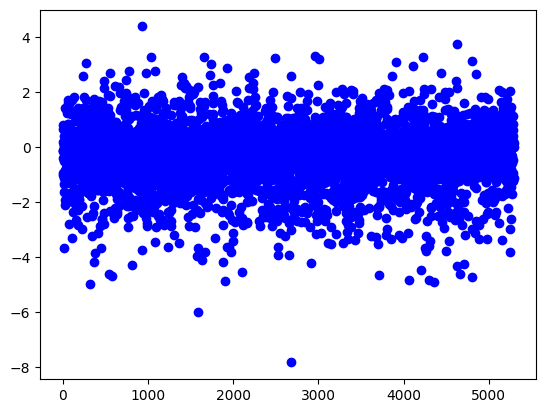

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(range(0, df.shape[0]), list(np.array(outputs)-np.array(y_true)), color ='b')
plt.show()